In [5]:
%matplotlib inline

from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import pickle   

import warnings
warnings.filterwarnings('ignore')
from clean_data import *


In [6]:
def load_dataset(mins_diff=5):
    df = pd.read_csv('../data/CleanData/traveltimes_all_2014_15_16.csv')

    df.tijd = pd.to_datetime(df.tijd)
    [df[c].fillna(df[c].min(), inplace=True) for c in df.columns if c != 'tijd']

    jam_threshold = df.E_F.quantile(.75)

    y = (df.E_F > jam_threshold)[mins_diff:]
    df = df.iloc[:-mins_diff,:]

    del df['tijd']
    return df, y

def train_test_split(df, test_size=0.3):
    cut = int(len(y) * test_size)

    X_train = df.iloc[:-cut,:]
    X_test = df.iloc[-cut:,:]

    y_train = y[:-cut]
    y_test = y[-cut:]

    return X_train, X_test, y_train, y_test


In [7]:
df, y = load_dataset(mins_diff=5)

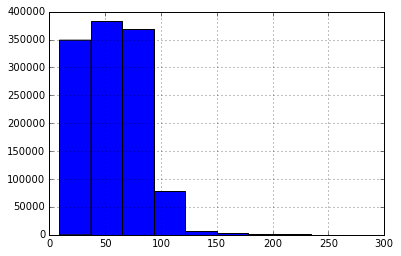

In [8]:
df.E_F.hist()

In [9]:
X_train, X_test, y_train, y_test =  train_test_split(df, test_size=0.3)

In [16]:
def train_eval_classifier(X_train, X_test, y_train, y_test):
    params = dict(
        max_depth=[20, 30],
        n_estimators=[50, 70, 100],
    )

    score = 'f1'

    clf = GridSearchCV(
        RandomForestClassifier(),  
        param_grid=params,  # parameters to tune via cross validation
        refit=True,  # fit using all data, on the best detected classifier
        n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
        scoring=score,  # what score are we optimizing?
        cv=StratifiedKFold(y_train, n_folds=3),  # what type of cross validation to use
    )

    clf.fit(X_train, y_train)
    y_true, y_pred = y_test, clf.predict(X_test)
    clf.best_params_

    print(classification_report(y_true, y_pred))

    return clf


In [17]:
clf = train_eval_classifier(X_train, X_test, y_train, y_test)
clf.best_params_

             precision    recall  f1-score   support

      False       0.93      0.95      0.94    272717
       True       0.82      0.78      0.80     84542

avg / total       0.91      0.91      0.91    357259



{'max_depth': 20, 'n_estimators': 50}

In [13]:
 with open('travel_dataset_5m.pickle','wb') as f:
    pickle.dump((X_train,X_test,y_train,y_test),f)